In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [2]:
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

import cv2
#image = cv2.imread("path")
#rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

from IPython import display

template = "numpy: v{np},  opencv: v{cv},  tensorflow: v{tf}"
print(template.format(np=np.__version__,
                      cv=cv2.__version__,
                      tf=tf.__version__))

numpy: v1.17.5,  opencv: v4.1.2,  tensorflow: v2.1.0


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
HIDDEN_DIM = 100
NUM_EXAMPLES = 16
SEED = tf.random.normal([NUM_EXAMPLES, HIDDEN_DIM])

EPOCHS = 50
CHECKPOINTS_PREFIX = "checkpoint"
CHECKPOINTS_DIR = "./checkpoints"

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    template = "image_at_epoch_{:04d}.png"
    plt.savefig(template.format(epoch))
    plt.show()

In [0]:
def create_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(HIDDEN_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

def create_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [0]:
class Generator:
    def __init__(self, optimizer=Adam(1e-4)):
        super(Generator, self).__init__()
        self.model = None # use make_model method
        self.optimizer = optimizer
        self.make_model()
        self.up_stack = [
            self.upsample(128, (5, 5), strides=(1, 1)),
            self.upsample(64, (5, 5), strides=(2, 2))
        ]

    #@tf.function -- prepare it
    def make_model(self, model_type="G"):
        '''
        self.model = Sequential()
        self.model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(HIDDEN_DIM,)))
        self.model.add(BatchNormalization())
        self.model.add(LeakyReLU())
        self.model.add(Reshape((7, 7, 256)))
        for up in self.up_stack:
            self.model.add(up)
        self.model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh"))
        '''
        if model_type == "G":
            self.model = create_generator()
        elif model_type == "D":
            self.model = create_discriminator()

    def __call__(self, x, training):
        return self.model(x, training)

    def upsample(self, filters, size, strides, apply_dropout=False):
        result = Sequential()
        result.add(Conv2DTranspose(filters, size, strides=strides))
        if apply_dropout:
            result.add(Dropout(0.5))
        result.add(BatchNormalization())
        result.add(LeakyReLU())

        return result

In [0]:
class Discriminator:
    def __init__(self, optimizer=Adam(1e-4)):
        super(Discriminator, self).__init__()
        self.model = None # use make_model method
        self.optimizer = optimizer
        self.make_model()

    #@tf.function -- prepare it
    def make_model(self, model_type="D"):
        '''
        self.model = Sequential()
        self.model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(HIDDEN_DIM,)))
        self.model.add(BatchNormalization())
        self.model.add(LeakyReLU())
        self.model.add(Reshape((7, 7, 256)))
        for up in self.up_stack:
            self.model.add(up)
        self.model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh"))
        '''
        if model_type == "G":
            self.model = create_generator()
        elif model_type == "D":
            self.model = create_discriminator()

    def __call__(self, x, training):
        return self.model(x, training)

In [0]:
class Extractor:
    def __init__(self, optimizer=Adam(1e-4)):
        super(Extractor, self).__init__()
        self.model = None
        self.optimizer = optimizer
        self.make_model()
    pass

In [0]:
crossentropy = BinaryCrossentropy(from_logits=True)

def calculate_generator_loss(fake_output):
    return crossentropy(tf.ones_like(fake_output), fake_output)

def calculate_discriminator_loss(real_output, fake_output):
    real_loss = crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [10]:
'''
generator = create_generator()
generator_optimizer = Adam(1e-4)

discriminator = create_discriminator()
discriminator_optimizer = Adam(1e-4)
'''

'\ngenerator = create_generator()\ngenerator_optimizer = Adam(1e-4)\n\ndiscriminator = create_discriminator()\ndiscriminator_optimizer = Adam(1e-4)\n'

In [0]:
generator = Generator()
discriminator = Discriminator()
extractor = Extractor()

tf.Tensor([[-0.00129142]], shape=(1, 1), dtype=float32)


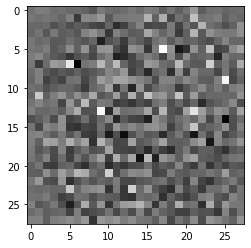

In [12]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(decision)

In [13]:
'''
@tf.function
def train_step(images_batch):
    hidden = tf.random.normal([BATCH_SIZE, HIDDEN_DIM])
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images_batch = generator(hidden, training=True)
        real_output = discriminator(images_batch, training=True)
        fake_output = discriminator(generated_images_batch, training=True)
        
        generator_loss = calculate_generator_loss(fake_output)
        discriminator_loss = calculate_discriminator_loss(real_output, fake_output)
        
    generator_gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
'''

'\n@tf.function\ndef train_step(images_batch):\n    hidden = tf.random.normal([BATCH_SIZE, HIDDEN_DIM])\n    \n    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:\n        generated_images_batch = generator(hidden, training=True)\n        real_output = discriminator(images_batch, training=True)\n        fake_output = discriminator(generated_images_batch, training=True)\n        \n        generator_loss = calculate_generator_loss(fake_output)\n        discriminator_loss = calculate_discriminator_loss(real_output, fake_output)\n        \n    generator_gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)\n    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)\n\n    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))\n    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))\n'

In [14]:
'''
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs=EPOCHS, seed=SEED):
    for epoch in range(epochs):
        start = time.time()
        for images_batch in dataset:
            train_step(images_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 3 == 0:
            checkpoint.save(file_prefix=CHECKPOINTS_PREFIX)
        template = "Time for epoch {} is {} sec"
        print(template.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
'''

'\ncheckpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                 discriminator_optimizer=discriminator_optimizer,\n                                 generator=generator,\n                                 discriminator=discriminator)\n\ndef train(dataset, epochs=EPOCHS, seed=SEED):\n    for epoch in range(epochs):\n        start = time.time()\n        for images_batch in dataset:\n            train_step(images_batch)\n        display.clear_output(wait=True)\n        generate_and_save_images(generator, epoch + 1, seed)\n        if (epoch + 1) % 3 == 0:\n            checkpoint.save(file_prefix=CHECKPOINTS_PREFIX)\n        template = "Time for epoch {} is {} sec"\n        print(template.format(epoch + 1, time.time()-start))\n    display.clear_output(wait=True)\n    generate_and_save_images(generator, epochs, seed)\n'

In [0]:
@tf.function
def train_step2(images_batch):
    hidden = tf.random.normal([BATCH_SIZE, HIDDEN_DIM])
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images_batch = generator(hidden, training=True)
        real_output = discriminator(images_batch, training=True)
        fake_output = discriminator(generated_images_batch, training=True)
        
        generator_loss = calculate_generator_loss(fake_output)
        discriminator_loss = calculate_discriminator_loss(real_output, fake_output)
        
    generator_gradients = generator_tape.gradient(generator_loss, generator.model.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator.model.trainable_variables)

    generator.optimizer.apply_gradients(zip(generator_gradients, generator.model.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(discriminator_gradients, discriminator.model.trainable_variables))

In [0]:
checkpoint2 = tf.train.Checkpoint(generator_optimizer=generator.optimizer,
                                 discriminator_optimizer=discriminator.optimizer,
                                 generator=generator.model,
                                 discriminator=discriminator.model)

def train2(dataset, epochs=EPOCHS, seed=SEED):
    for epoch in range(epochs):
        start = time.time()
        for images_batch in dataset:
            train_step2(images_batch)
        #display.clear_output(wait=True)
        generate_and_save_images(generator.model, epoch + 1, seed)
        if (epoch + 1) % 3 == 0:
            checkpoint2.save(file_prefix=CHECKPOINTS_PREFIX)
        template = "Time for epoch {} is {} sec"
        print(template.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator.model, epochs, seed)

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

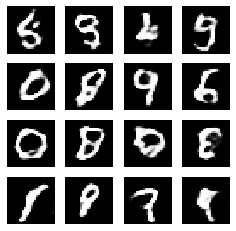

In [21]:
train2(train_dataset, EPOCHS)